In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder


import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!pip install catboost
!pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.3 MB/s eta 0:00:00


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
dic = {
    '10+ years':10.0,
    '9 years': 9.0,
    '8 years': 8.0,
    '7 years': 7.0,
    '6 years': 6.0,
    '5 years': 5.0,
    '4 years': 4.0,
    '3 years': 3.0,
    '2 years': 2.0,
    '1 year': 1.0,
    '< 1 year': 0.0
}

# Make a list with each of the regions by state.
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'

In [6]:
X_train = pd.read_csv('/kaggle/input/lending/X_train.csv')
y_train = pd.read_csv('/kaggle/input/lending/y_train.csv')
X_test = pd.read_csv('/kaggle/input/lending/X_test.csv')
X_train = X_train.merge(y_train, on = 'index')

X_train['train'] = 1
X_train['test'] = 0

X_test['test'] = 1
X_test['train'] = 0
X_test['loan_status'] = -999

In [7]:
submission = pd.DataFrame()
submission['index'] = X_test['index']
quant = X_train['annual_inc'].quantile(q = 0.99)
X_train = X_train[(X_train['annual_inc']<=quant)]

df_merge = pd.concat([X_train, X_test])
df_merge.drop(columns = ['title','zip_code'], inplace=True)

X_train = 0
y_train = 0
X_test = 0

In [8]:
# df_merge['term'] = df_merge['term'].str.rstrip('months').astype('int')

df_merge['fico_range_mean'] =  (df_merge['fico_range_high'] + df_merge['fico_range_low'])/2
df_merge['int_rate']  = df_merge['int_rate'].str.rstrip('%').astype('float')
df_merge['revol_util']  = df_merge['revol_util'].str.rstrip('%').astype('float')
df_merge["earliest_cr_line"] = pd.to_datetime(df_merge["earliest_cr_line"], format="%b-%Y")
df_merge['year'] = df_merge["earliest_cr_line"].dt.year

df_merge['emp_length'] = df_merge['emp_length'].replace(dic)

df_merge['region'] = df_merge['addr_state'].apply(finding_regions)

df_merge['home_ownership'] = df_merge['home_ownership'].replace(['NONE','ANY'],'OTHER')
df_merge["verification_status"] = df_merge.verification_status.str.replace("Source Verified", "Verified")
df_merge["amnt_to_inc_ratio"] = df_merge.loan_amnt / df_merge.annual_inc




fill_columns = list()
for column in df_merge.columns:
    if df_merge[column].isna().sum() != 0:
        missing = df_merge[column].isna().sum()
        portion = (missing / df_merge.shape[0]) * 100
        # print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")
        if portion < 40:
            fill_columns.append(column)

for fill_med in fill_columns:
    df_merge[fill_med] = df_merge.groupby("addr_state")[fill_med].transform(
      lambda x: x.fillna(x.mean()))

label_col = [['verification_status'],['addr_state'], ['term']]
for col in label_col:
    df_merge[col] = df_merge[col].apply(LabelEncoder().fit_transform)
# high corr - num_sats, funded_amnt ,installment
drop_col = ['fico_range_high','mths_since_recent_bc_dlq',
            'earliest_cr_line', 'fico_range_low','issue_d', 'num_sats',
            'funded_amnt','installment','chargeoff_within_12_mths',
            'acc_now_delinq','tax_liens','collections_12_mths_ex_med'
            ]

df_merge.drop(columns = drop_col, inplace=True)

df_merge['purpose'] = df_merge['purpose'].replace(['educational','vacation',
                                               'renewable_energy','wedding',
                                               'house','moving','home_improvement',
                                                   'major_purchase','medical','car'
                                                   ],'other')
df_merge['purpose'] = df_merge['purpose'].replace(['credit_card'],'debt_consolidation')


df_merge = pd.get_dummies(df_merge)

In [10]:
target_col = ['inq_last_12m','open_il_24m', 'open_rv_24m']
df_miss = df_merge[(df_merge['inq_last_12m'].isna())&
              (df_merge['open_il_24m'].isna())&
              (df_merge['open_rv_24m'].isna())]

df_with = df_merge[~(df_merge['inq_last_12m'].isna())&
              ~(df_merge['open_il_24m'].isna())&
              ~(df_merge['open_rv_24m'].isna())]

musor = ['inq_last_12m','open_il_24m','open_rv_24m','index',
         'train', 'test','loan_status','mths_since_last_delinq']
df_with = pd.get_dummies(df_with)
df_miss = pd.get_dummies(df_miss)

In [11]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

X = df_with.drop(columns = musor, axis=1)
y = df_with[target_col]

regr = MultiOutputRegressor(LGBMRegressor()).fit(X, y)
y_target = regr.predict(df_miss.drop(columns = musor , axis=1))
df_miss[target_col] = y_target.round(0)

In [12]:
df_merge = pd.concat([df_with, df_miss])
df_with = 0
df_miss = 0
X = 0
y= 0
gc.collect()

200

In [13]:
df_miss = df_merge[df_merge['mths_since_last_delinq'].isna()]
df_with = df_merge[~df_merge['mths_since_last_delinq'].isna()]

musor = ['train', 'test','loan_status','mths_since_last_delinq','index']
X = df_with.drop(columns = musor, axis=1)
y = df_with['mths_since_last_delinq']

In [14]:
from lightgbm import LGBMRegressor
regr_lgb = LGBMRegressor().fit(X, y)
y_target = regr_lgb.predict(df_miss.drop(columns = musor, axis=1))
df_miss['mths_since_last_delinq'] = y_target.round(0)

/tmp/ipykernel_32/2496962480.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_miss['mths_since_last_delinq'] = y_target.round(0)


In [15]:
df_merge = pd.concat([df_with, df_miss])
df_with = 0
df_miss = 0
X = 0
y= 0
gc.collect()

0

In [22]:
df_test = df_test.sort_values(by=['index'])
y_train = df_merge['loan_status'][df_merge['train']==1]

df_train = df_merge[df_merge['train']==1]
df_test = df_merge[df_merge['test']==1]
df_train = df_train.drop(columns = ['loan_status','train','test','index'])
df_test = df_test.drop(columns = ['loan_status','train','test','index'])

feature_col = df_train.columns.to_list()
name_feature_col = df_train.columns.to_list()

In [42]:
num_feature = [
               'delinq_2yrs','dti','emp_length','inq_last_12m','int_rate',
               'loan_amnt', 'mort_acc','mths_since_last_delinq', 'mths_since_recent_inq',
               'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_rev_accts',
               'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
               'num_tl_op_past_12m', 'open_acc', 'open_il_24m', 'open_rv_24m',
               'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'revol_util',
                'total_acc','fico_range_mean',
               'amnt_to_inc_ratio', 'annual_inc',
               ]
               
scaler = StandardScaler()
# scaler = MinMaxScaler()

df_train[num_feature] = scaler.fit_transform(df_train[num_feature].values)
df_test[num_feature] =  scaler.fit_transform(df_test[num_feature].values)

In [68]:
splitter=StratifiedShuffleSplit(n_splits=1, random_state=1824, test_size=0.2) #we can make a number of combinations of split

for train,test in splitter.split(df_train, y_train):     #this will splits the index
    X_train_SS = df_train.iloc[train]
    y_train_SS = y_train.iloc[train]
    X_test_SS = df_train.iloc[test]
    y_test_SS = y_train.iloc[test]

In [69]:
from lightgbm import LGBMClassifier
clf_lgb = LGBMClassifier(objective= 'binary',
                         metric= 'auc',
                         max_depth= -1,
                         num_leaves = 40,
                         num_iterations = 600,
                         n_estimators = 400,
                         early_stopping_round=10,
                         subsample = 0.665,
                         reg_lambda = 5,
                         reg_alpha = 2,
                         min_child_weight = 1000,
                         min_child_samples = 422,
                         colsample_bytree = 0.82,
                         )

clf_lgb.fit(X_train_SS, y_train_SS, eval_set=(X_test_SS, y_test_SS),verbose=-1)
y_hat = clf_lgb.predict_proba(X_test_SS)[:, 1]
print(roc_auc_score(y_test_SS,y_hat ))

/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


0.7246323145913804


<Axes: ylabel='Feature'>

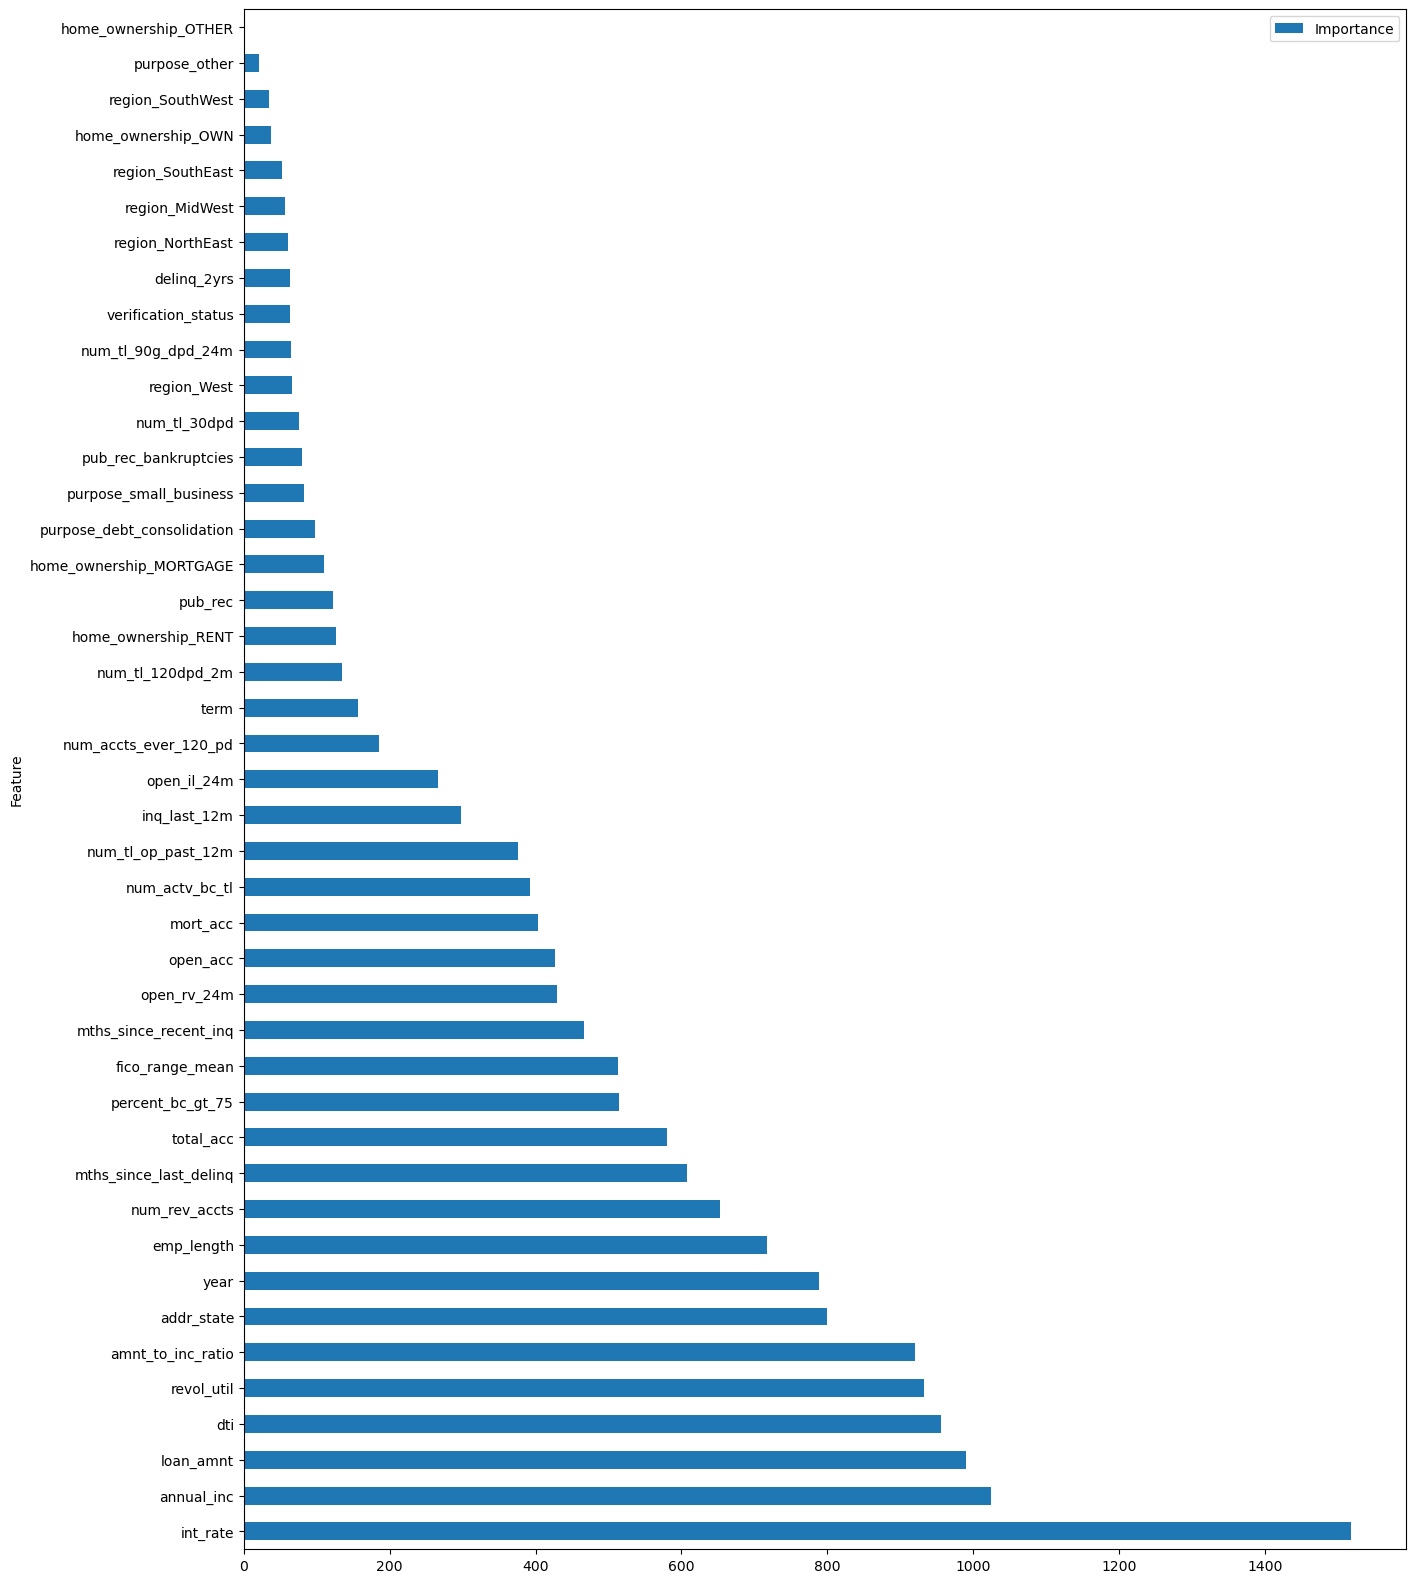

In [70]:
coefficients = clf_lgb.feature_importances_
feature_importance = pd.DataFrame({'Feature': name_feature_col, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(15, 20))


In [71]:
# 0.7238
from catboost import CatBoostClassifier, Pool
cat_clf = CatBoostClassifier(verbose=100,
                             eval_metric='AUC',
                             iterations=1000)
cat_clf.fit(X_train_SS, y_train_SS,
            eval_set=(X_test_SS, y_test_SS),
            early_stopping_rounds=10,
            use_best_model=True,
            )
y_hat = cat_clf.predict_proba(X_test_SS)[:, 1]
print(roc_auc_score(y_test_SS,y_hat ))

Learning rate set to 0.172361
0:	test: 0.6861677	best: 0.6861677 (0)	total: 442ms	remaining: 7m 21s
100:	test: 0.7188959	best: 0.7188959 (100)	total: 32.3s	remaining: 4m 47s
200:	test: 0.7221355	best: 0.7221355 (200)	total: 1m 4s	remaining: 4m 14s
300:	test: 0.7231301	best: 0.7231301 (300)	total: 1m 34s	remaining: 3m 40s
400:	test: 0.7237005	best: 0.7237005 (400)	total: 2m 5s	remaining: 3m 7s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7237111509
bestIteration = 408

Shrink model to first 409 iterations.
0.7237111509284935


<Axes: ylabel='Feature'>

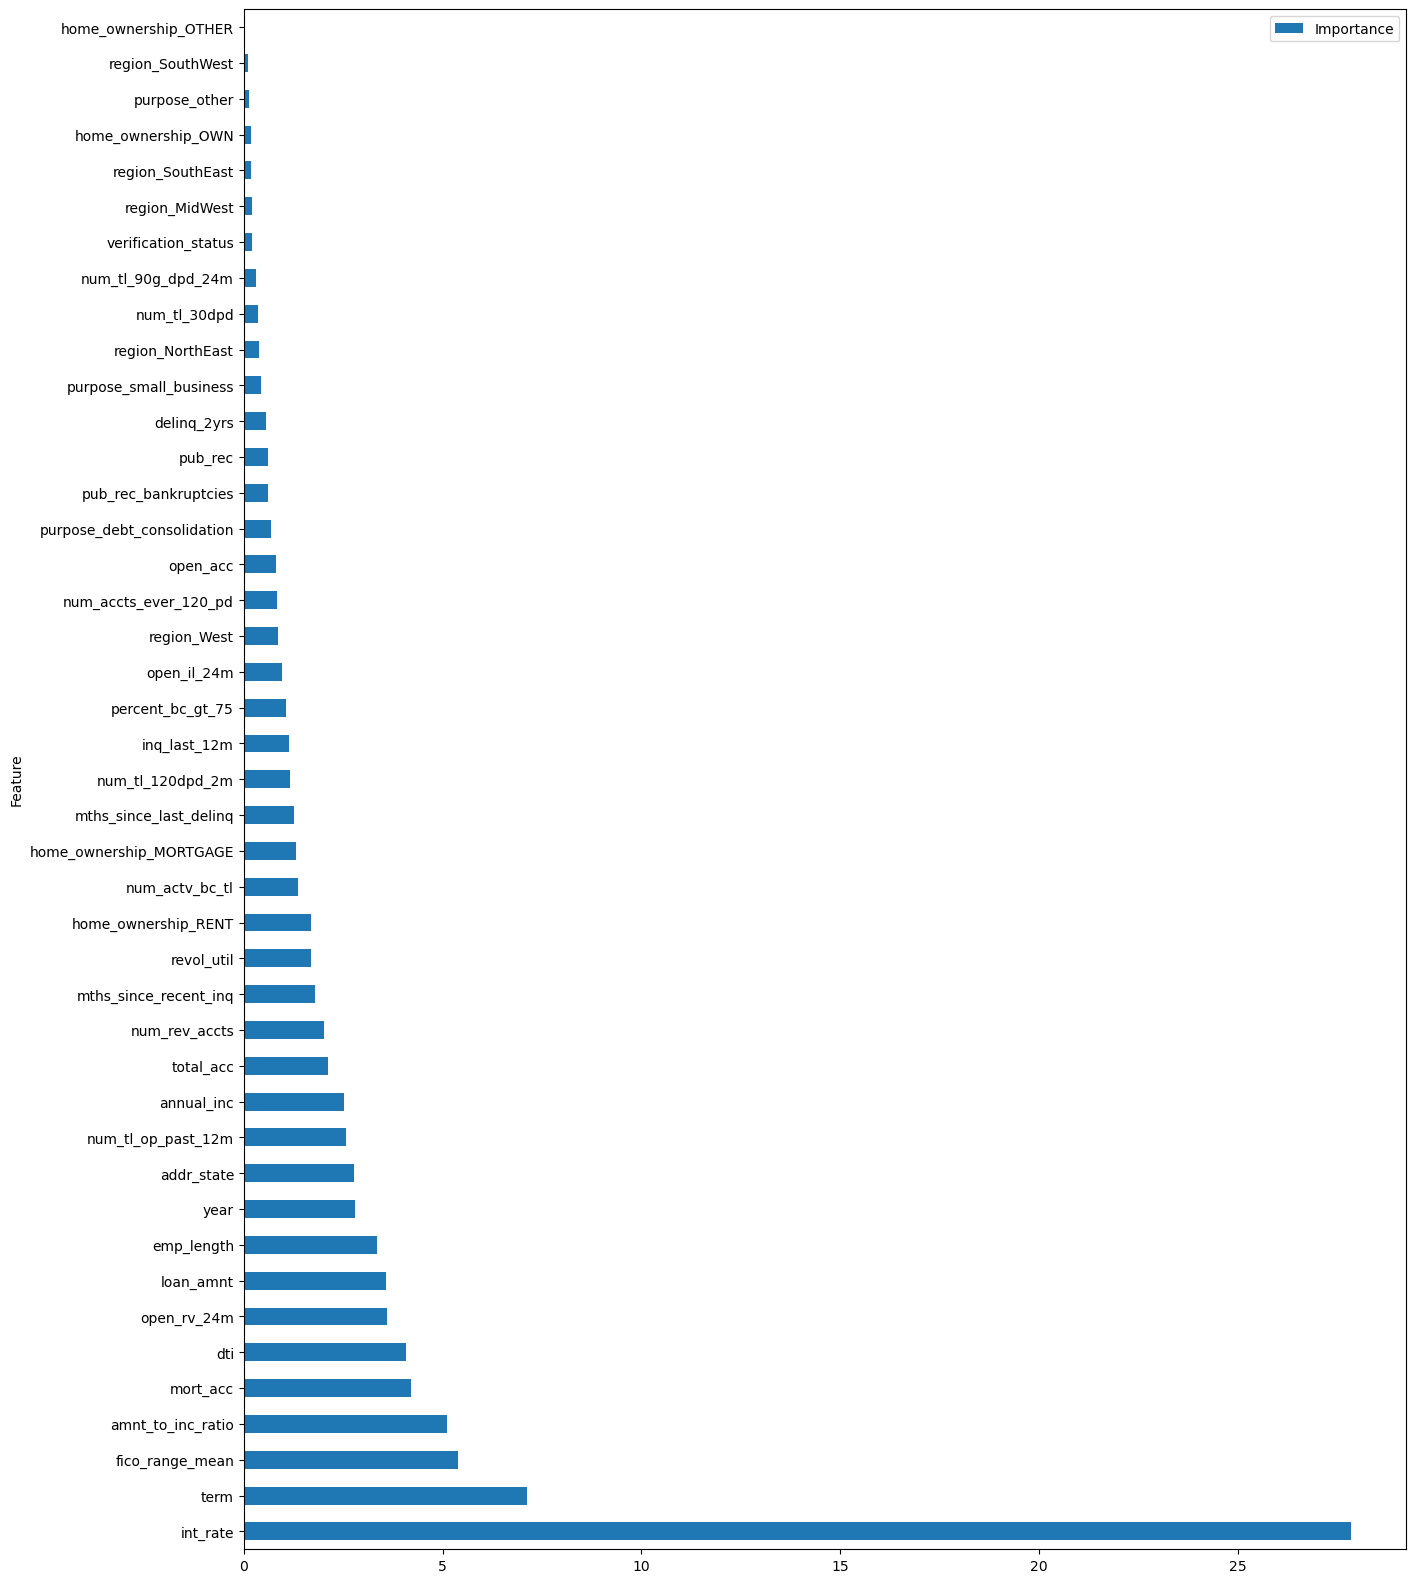

In [72]:
coefficients = cat_clf.feature_importances_
feature_importance = pd.DataFrame({'Feature': feature_col, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(15, 20))


In [73]:
from xgboost import XGBClassifier
#0.72
clf_xgb = XGBClassifier(objective='binary:logistic',
                        n_estimators=300,
                        early_stopping_rounds=10)
clf_xgb.fit(X_train_SS, y_train_SS,
            eval_set=[(X_train_SS, y_train_SS),(X_test_SS, y_test_SS)],
            verbose=10)

y_hat = clf_xgb.predict_proba(X_test_SS)[:, 1]
print(roc_auc_score(y_test_SS,y_hat ))

[0]	validation_0-logloss:0.58476	validation_1-logloss:0.58484
[10]	validation_0-logloss:0.44622	validation_1-logloss:0.44776
[20]	validation_0-logloss:0.44113	validation_1-logloss:0.44433
[30]	validation_0-logloss:0.43855	validation_1-logloss:0.44323
[40]	validation_0-logloss:0.43662	validation_1-logloss:0.44257
[50]	validation_0-logloss:0.43516	validation_1-logloss:0.44217
[60]	validation_0-logloss:0.43399	validation_1-logloss:0.44199
[70]	validation_0-logloss:0.43266	validation_1-logloss:0.44188
[80]	validation_0-logloss:0.43162	validation_1-logloss:0.44174
[90]	validation_0-logloss:0.43071	validation_1-logloss:0.44175
0.7205282722524382


<Axes: ylabel='Feature'>

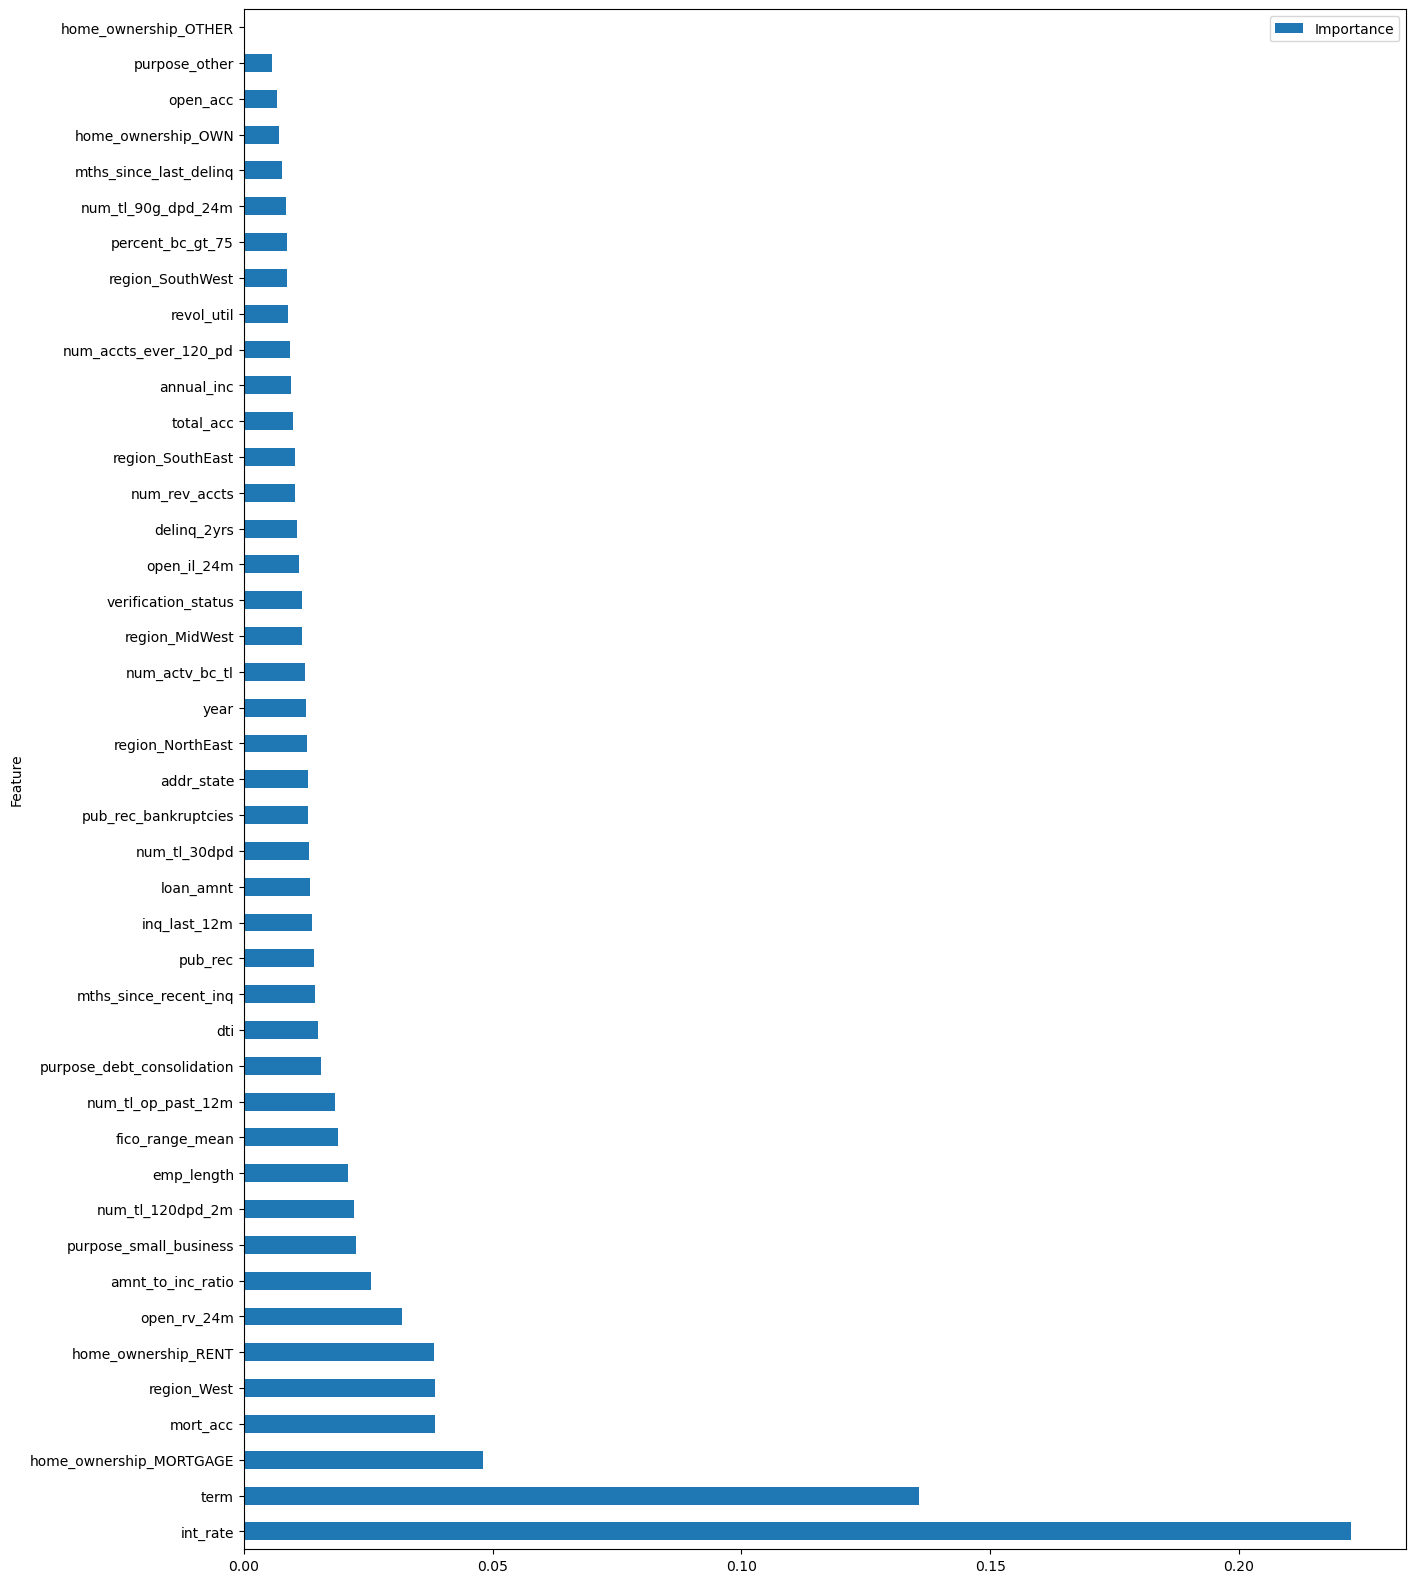

In [74]:
coefficients = clf_xgb.feature_importances_
feature_importance = pd.DataFrame({'Feature': feature_col, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(15, 20))

## tabnet

In [65]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
from pytorch_tabnet.tab_model import TabNetClassifier

clf_tab_net = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.03),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [67]:
aug = ClassificationSMOTE(p=0.1)
max_epochs = 100

clf_tab_net.fit(
    X_train=X_train_SS.to_numpy(), y_train=y_train_SS,
    eval_set=[(X_test_SS.to_numpy(), y_test_SS)],
    eval_name=['valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs,
    augmentations=aug,
    patience = 5,
    batch_size=1024,
)

epoch 0  | loss: 0.46092 | valid_auc: 0.70292 |  0:00:46s
epoch 1  | loss: 0.45069 | valid_auc: 0.70807 |  0:01:31s
epoch 2  | loss: 0.44911 | valid_auc: 0.71005 |  0:02:15s
epoch 3  | loss: 0.44799 | valid_auc: 0.71242 |  0:02:59s
epoch 4  | loss: 0.44758 | valid_auc: 0.71271 |  0:03:43s
epoch 5  | loss: 0.44725 | valid_auc: 0.71144 |  0:04:27s
epoch 6  | loss: 0.44661 | valid_auc: 0.71383 |  0:05:11s
epoch 7  | loss: 0.44606 | valid_auc: 0.7157  |  0:05:56s
epoch 8  | loss: 0.44596 | valid_auc: 0.71436 |  0:06:40s
epoch 9  | loss: 0.44569 | valid_auc: 0.71533 |  0:07:24s
epoch 10 | loss: 0.4455  | valid_auc: 0.71557 |  0:08:07s
epoch 11 | loss: 0.44546 | valid_auc: 0.7159  |  0:08:50s
epoch 12 | loss: 0.44529 | valid_auc: 0.7146  |  0:09:34s
epoch 13 | loss: 0.44525 | valid_auc: 0.71598 |  0:10:17s
epoch 14 | loss: 0.44542 | valid_auc: 0.71601 |  0:11:00s
epoch 15 | loss: 0.44504 | valid_auc: 0.71646 |  0:11:43s
epoch 16 | loss: 0.44493 | valid_auc: 0.71717 |  0:12:26s
epoch 17 | los

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


<Axes: ylabel='Feature'>

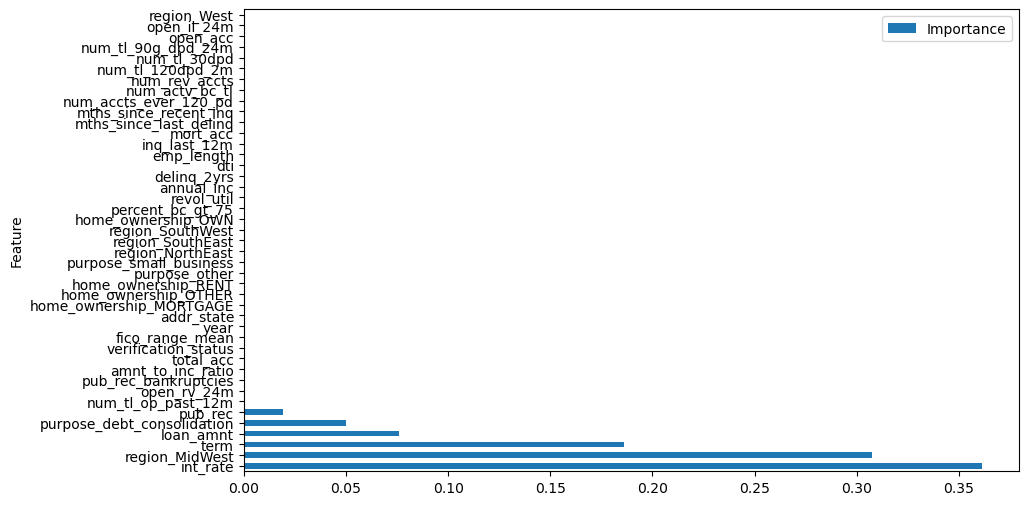

In [75]:
coefficients = clf_tab_net.feature_importances_

feature_importance = pd.DataFrame({'Feature': feature_col, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

## NN2

In [76]:
x_train_tensor =  torch.from_numpy(X_train_SS.values).float()
y_train_tensor =  torch.from_numpy(y_train_SS.values.ravel()).float()
x_test_tensor =  torch.from_numpy(X_test_SS.values).float()
y_test_tensor =  torch.from_numpy(y_test_SS.values.ravel()).float()

In [77]:
## train data
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__ (self):
        return len(self.X_data)

## test data
class TestData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
    def __getitem__(self, index):
        return self.X_data[index]
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(x_train_tensor, y_train_tensor)
test_data = TestData(x_test_tensor)

In [78]:
batch_size = 1024
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [79]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def resume(model, filename):
    model.load_state_dict(torch.load(filename))

In [167]:

#Layer size
n_input_dim = df_train.shape[1]
n_hidden1 = 60  # Number of hidden nodes
n_output =  1   # Number of output nodes = for binary classifier

class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1)
        self.layer_2 = nn.Linear(n_hidden1, n_hidden1)
        self.layer_3 = nn.Linear(n_hidden1, n_hidden1)
        self.layer_out = nn.Linear(n_hidden1, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm3 = nn.BatchNorm1d(n_hidden1)

        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_out(x)

        return x

In [168]:
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryClassification()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.001
weight_decay =1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=30)

In [169]:
best_accuracy = -1
best_epoch = -1
best_val_loss = 100
early_stop_thresh = 10
epochs = 100

for e in range(1, epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    scheduler.step()
    
    model.eval()
    y_pred = model(x_test_tensor.cuda())
    y_pred = torch.sigmoid(y_pred)
    val_loss = criterion(y_pred.cuda(), y_test_tensor.unsqueeze(1).cuda())
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = e
        checkpoint(model, "best_model.pth")
        print("save parameters at epoch %d" % e)
    elif e - best_epoch > early_stop_thresh:
        print("Early stopped training at epoch %d" % e)
        break  # terminate the training loop
    print(f'Epoch {e}: | Loss: {epoch_loss/len(train_loader):.5f}|val los:{val_loss:.5f} |auc = {roc_auc_score(y_test_tensor, y_pred.cpu().detach().numpy()):.3f}')
resume(model, "best_model.pth")


save parameters at epoch 1
Epoch 1: | Loss: 0.47774|val los:0.71777 |auc = 0.706
Epoch 2: | Loss: 0.45059|val los:0.73269 |auc = 0.705
Epoch 3: | Loss: 0.44923|val los:0.85760 |auc = 0.702
save parameters at epoch 4
Epoch 4: | Loss: 0.44875|val los:0.70457 |auc = 0.697
Epoch 5: | Loss: 0.44811|val los:0.79307 |auc = 0.693
Epoch 6: | Loss: 0.44807|val los:0.86703 |auc = 0.696
Epoch 7: | Loss: 0.44749|val los:0.74991 |auc = 0.700
Epoch 8: | Loss: 0.44762|val los:0.71922 |auc = 0.694
Epoch 9: | Loss: 0.44740|val los:0.71716 |auc = 0.698
Epoch 10: | Loss: 0.44727|val los:0.73511 |auc = 0.706
Epoch 11: | Loss: 0.44733|val los:1.02539 |auc = 0.697
Epoch 12: | Loss: 0.44726|val los:0.74633 |auc = 0.705
Epoch 13: | Loss: 0.44735|val los:0.82010 |auc = 0.692
Epoch 14: | Loss: 0.44719|val los:0.70690 |auc = 0.705
save parameters at epoch 15
Epoch 15: | Loss: 0.44758|val los:0.70089 |auc = 0.709
Epoch 16: | Loss: 0.44740|val los:0.74423 |auc = 0.704
Epoch 17: | Loss: 0.44728|val los:0.71348 |auc 

## submission

In [171]:
y_preds_lgb = clf_lgb.predict_proba(df_test.to_numpy())[:,1]
y_preds_xgb = clf_xgb.predict_proba(df_test.to_numpy())[:,1]
y_preds_catb = cat_clf.predict_proba(df_test.to_numpy())[:,1]
y_tab_net = clf_tab_net.predict_proba(df_test.to_numpy())[:,1]

In [177]:
model.eval()
submission_tensor = torch.from_numpy(df_test.to_numpy()).float()
# with torch.no_grad():
#     y_preds_torch = model(submission_tensor.cuda())
#     y_preds_torch = torch.sigmoid(y_preds_torch)
y_preds_torch = model(submission_tensor.cuda())
y_preds_torch = torch.sigmoid(y_preds_torch)
y_preds_torch = y_preds_torch.detach().cpu().numpy()
y_preds_torch = np.squeeze(y_preds_torch)

In [192]:

w_lgb = 0.4
w_xgb = 0.1
w_catb = 0.15
w_torch = 0.05
w_tab_net = 0.3

y_preds = w_lgb * y_preds_lgb + w_xgb * y_preds_xgb + w_catb * y_preds_catb +w_tab_net*y_tab_net+ w_torch*y_preds_torch


submission['loan_status'] = y_preds
compression_opts = dict(method='zip',archive_name='answer.csv')
submission.to_csv('answer.zip', index=False,compression=compression_opts)